# VIXM Predictor Feature Importance using an adaBoost Model

### Introduction

This notebook presents a machine learning model designed to predict the direction of returns for the VIXM ETN on the following trading day.
By constructing the algorith, we can see which features would be more important to predict the movements of the VIXM.

Next step is to check using other algorithms, tune a final model, and implement the trading strategy.

We extract or calculate a range of features from a predefined list of tickers using Yahoo Finance data. These features include:

- Close prices
- Returns
- Volume
- GARCH models for volatility estimation
- Squared returns
- SPY historical volatility
- Day-of-the-week and month-of-the-year seasonality effects
- Principal components analysis (PCA) lagged by 1 to 5 days, representing historical movements

The feature extraction and model training are organized into two separate modules:
> `vixcoin_functions/feature_functions.py`  
> `vixcoin_functions/pca_and_training.py`

The core of this strategy is powered by the **AdaBoost algorithm**, which generates daily signals (`0` or `1`). These signals dictate the trading strategy:  
- **Buy** VIXM when the signal is `1`  
- **Sell** VIXM when the signal returns to `0`

In addition to signal generation, the code provides the following analyses:
- Profitability assessment of the trading strategy
- Model accuracy evaluation
- Feature importance analysis
- Hyperparameter tuning for optimizing model performance



In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import sys
from pathlib import Path
import datetime as dt
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt

# Add vixcoin_functions to sys.path if not already included
module_path = str(Path("vixcoin_functions/"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import functions from feature_functions and pca_and_training modules
from feature_functions import (
    garch_fit_and_predict, correlation_filter,
    retrieve_yahoo_close, retrieve_yahoo_volume, retrieve_close_multiple_tickers,
    retrieve_volume, save_volume_to_csv, load_demo_volume, process_volume_data
)

from pca_and_training import (
    split_training_test_data,
    scale,
    adaboost_pca,
    create_pca_lag,
    concatenate_lags,
    combine_train_test,
    concatenate_with_pca_lags,
    eliminate_nans_in_pca_data,
    random_over_sample
)


# CONTROL PANEL

In [264]:
# Key parameters of the model

# Min return to set up a positive signal
threshold = 0.00 
seed = 19

# Split of data
training_period_months = 120 

# Adaboost parameters
adaboost_estimators = 6 
max_depth = 2
learning_rate_adaboost = 1.7 

# Inclusion of the first 5 components lagged
number_of_pca_lag_component_to_include = 5
num_pca_components = 40

# Definition of demo mode or development mode
demo_mode = False
tuning_mode = True
run_multiple_tuning_iterations = False

# Dates
start_date = '2014-02-01'
end_date = '2024-09-26'

start_date_volatilities = (pd.to_datetime(start_date) + DateOffset(days=-364)).date()


print(f"start date: {start_date}, end date: {end_date}, start date rolling volatilities: {start_date_volatilities}")


start date: 2014-02-01, end date: 2024-09-26, start date rolling volatilities: 2013-02-02


# Generation of the Features Matrix X

### X1: close prices
#### 40 units: 
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [265]:
# Ticker List: VIX must be in first position
ticker_list = [
    'VIXM', '^VIX', 'SPY', 'GBPUSD=X', 'BRLUSD=X', 'DX-Y.NYB', 'USDJPY=X',
    '^TNX', 'ZF=F', 'NQ=F', 'NKD=F', 'LQD', 'AAPL', 'AMZN', 'MU', 'MSFT',
    'BMY', 'PLD', 'FXI', 'FEZ', '^FTSE', '^FCHI', '^GSPC', 'GLD', 'SLV',
    'ES=F', 'QM=F', 'BIO=F', 'AGG'
]

"""
Some of the less familiar tickers are listed below, together with others that can be good to try again in the future
Bristol-Myers Squibb Company (BMY)
E-Mini Nasdaq                (BIO=F)
Euro spot                    (EURUSD)
E-Mini S&P500                (ES=F)
CAC 40                       (^FCHI)
FTSE 100                     (^FTSE)
SPDR EURO STOXX 50 ETF       (FEZ)
FEDEX CORP                   (FDX)
The Goldman Sachs Group, Inc.(GS)
DAX PERFORMANCE-INDEX        (^GDAXI)
S&P500 Index                 (^GSPC)
HANG SENG INDEX              (^HSI)
13 Week Treasury Bill        (^IRX) 
iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD)
Micron Technology, Inc.      (MU)
Microsoft Corporation        (MSFT)
Nikkei/USD Futures,Dec-2021 (NKD=F)
Nasdaq 100 Dec 21           (NQ=F)
NVIDIA Corporation          (NVDA)
E-Mini oil                  (QM=F)
Prologis, Inc.              (PLD)
Treasury Yield 10 Years     (^TNX) -- 1985
Yen Denominated TOPIX Futures,D   (TPY=F)
American Funds U.S. Government Securities Fund Class C (UGSCX) - 2001
Energy Select Sector SPDR Fund    (XLE)
Financial Select Sector SPDR Fund (XLF)
U.S. Treasury Bond Futures,Dec-   (ZB=F) - 2000
Five-Year US Treasury Note Futu   (ZF=F) - 2000
"""

print(f"Current number of tickers: {len(ticker_list)}")


Current number of tickers: 29


In [266]:
# X1: Upload of close prices data using yahoo API

# Obs: raw means that the data can contain missing values
# In case of demo mode would use data stored in the csv file 
if demo_mode == True:
    close_prices_df_raw = pd.read_csv(
        "demo_data/adaboost_close_prices.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
# In the general case retrieve from the API and save updated data to CVS file to use in future demo as needed
    close_prices_df_raw = retrieve_close_multiple_tickers(
        ticker_list, start_date=start_date, end_date=end_date
    )
                         
    close_prices_df_raw.to_csv("demo_data/adaboost_close_prices.csv", index=True)
print("Completed retrieve of close prices")

Processing Close VIXM
Processing Close ^VIX
Processing Close SPY
Processing Close GBPUSD=X
Processing Close BRLUSD=X
Processing Close DX-Y.NYB
Processing Close USDJPY=X
Processing Close ^TNX
Processing Close ZF=F
Processing Close NQ=F
Processing Close NKD=F
Processing Close LQD
Processing Close AAPL
Processing Close AMZN
Processing Close MU
Processing Close MSFT
Processing Close BMY
Processing Close PLD
Processing Close FXI
Processing Close FEZ
Processing Close ^FTSE
Processing Close ^FCHI
Processing Close ^GSPC
Processing Close GLD
Processing Close SLV
Processing Close ES=F
Processing Close QM=F
Processing Close BIO=F
Processing Close AGG
Completed retrieve of close prices


In [267]:
close_prices_df_raw.head()


,VIXM,^VIX,SPY,GBPUSD=X,BRLUSD=X,DX-Y.NYB,USDJPY=X,^TNX,ZF=F,NQ=F,...,FEZ,^FTSE,^FCHI,^GSPC,GLD,SLV,ES=F,QM=F,BIO=F,AGG
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,82.040001,21.440001,144.008209,1.643791,0.412831,81.010002,102.192001,2.581,120.968750,3430.00,...,28.402304,6465.700195,4107.750000,1741.890015,121.320000,18.610001,1732.75,96.425003,2492.399902,82.493347
2014-02-04,82.639999,19.110001,145.016937,1.630896,0.410307,81.120003,101.141998,2.624,120.875000,3452.00,...,28.657593,6449.299805,4117.450195,1755.199951,120.989998,18.750000,1743.75,97.199997,2520.000000,82.295212
2014-02-05,83.800003,19.950001,144.835037,1.633053,0.415559,81.029999,101.689003,2.667,120.757812,3445.50,...,28.708656,6457.899902,4117.790039,1751.640015,121.290001,19.070000,1744.00,97.375000,2477.300049,82.089394
2014-02-06,81.239998,17.230000,146.745056,1.632706,0.417449,80.889999,101.466003,2.702,120.648438,3487.25,...,29.350515,6558.299805,4188.100098,1773.430054,121.239998,19.170000,1766.50,97.849998,2475.000000,82.051292
2014-02-07,78.160004,15.290000,148.564041,1.632200,0.420256,80.690002,102.039001,2.675,120.914062,3558.00,...,29.802732,6571.700195,4228.180176,1797.020020,122.169998,19.270000,1793.50,99.875000,2572.500000,82.180893


In [268]:
# X1 (close prices) - Fill of missing values
close_prices_df = close_prices_df_raw.ffill(axis='rows')

# Apply correlation filter to keep just series with some minimum level of correlation of 0.05
close_prices_component_df = correlation_filter(
    close_prices_df, min_corr=0.05, key_column='VIXM', eliminate_first_column=False)

In [269]:
# Filling price_t with price_t-1 if price_t not available
close_prices_component_df  = close_prices_component_df.ffill(axis='rows')

# First columns is not given back, so we take opportunity to rename them
X1_no_suffix = close_prices_component_df
X1 = X1_no_suffix.add_suffix("_close")

# Additional time series for easy manipulation of VIXM close and returns
vixm = X1['VIXM_close']
vixm_ret = X1['VIXM_close'].pct_change()

vixm = pd.DataFrame([vixm]).T
vixm.columns = ['VIXM']  # 'vixm' will represent the close and 'vixm_ret' the return

vixm_ret = pd.DataFrame([vixm_ret]).T
vixm_ret.columns = ['VIXM_ret']

if demo_mode == False:
        print(X1.tail())

print("Completed inclusion of close prices")

            VIXM_close  ^VIX_close   SPY_close  GBPUSD=X_close  \
Date                                                             
2024-09-20       14.78       16.15  568.250000        1.328180   
2024-09-23       14.87       15.89  569.669983        1.331398   
2024-09-24       14.80       15.39  571.299988        1.334989   
2024-09-25       14.93       15.41  570.039978        1.342732   
2024-09-26       14.93       15.41  570.039978        1.331579   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2024-09-20        0.184369      100.720001      142.858002       3.728   
2024-09-23        0.181370      100.919998      144.003998       3.739   
2024-09-24        0.180633      100.370003      143.638000       3.736   
2024-09-25        0.183496      100.919998      142.962997       3.781   
2024-09-26        0.182688      100.559998      144.682999       3.781   

            ZF=F_c

In [270]:
# close_prices_df
X1.columns

Index(['VIXM_close', '^VIX_close', 'SPY_close', 'GBPUSD=X_close',
       'BRLUSD=X_close', 'DX-Y.NYB_close', 'USDJPY=X_close', '^TNX_close',
       'ZF=F_close', 'NQ=F_close', 'NKD=F_close', 'LQD_close', 'AAPL_close',
       'AMZN_close', 'MU_close', 'MSFT_close', 'BMY_close', 'PLD_close',
       'FXI_close', 'FEZ_close', '^FTSE_close', '^FCHI_close', '^GSPC_close',
       'GLD_close', 'SLV_close', 'ES=F_close', 'QM=F_close', 'BIO=F_close',
       'AGG_close'],
      dtype='object')

In [271]:
# Presentation graphs of the SPY and the VIX
presentation_graph = pd.concat([X1['SPY_close'], 2.5 * X1['VIXM_close']], axis=1).hvplot(
        title='VIXM and S&P (Scale adjusted)',
        width=650
)

graph1 = X1['SPY_close'].hvplot(
                title='SPY: iShares S&P 500 ETF Close Price',
                ylabel='Close Price [$]',
                width=650
) 
presentation_graph + graph1

:Layout
   .NdOverlay.I     :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.SPY_close :Curve   [Date]   (SPY_close)

### X2: security returns

In [272]:
# Inclusion of security returns X2
# Include returns that are (minimal) correlated with the VIXM return

security_returns_df = close_prices_df.pct_change()
security_returns_component_df = correlation_filter(                            
        security_returns_df, 
        min_corr=0.05, 
        key_column='VIXM', 
        eliminate_first_column=False
)

# The generation of a suffix is necesary when evaluating feature importance for time series identification
X2_no_suffix = security_returns_component_df
X2 = X2_no_suffix.add_suffix('_returns')

if demo_mode == False:
    display(X2)
        
print("Completed inclusion of returns")


,VIXM_returns,^VIX_returns,SPY_returns,^TNX_returns,ZF=F_returns,NQ=F_returns,NKD=F_returns,LQD_returns,AAPL_returns,AMZN_returns,...,PLD_returns,FXI_returns,FEZ_returns,^FTSE_returns,^FCHI_returns,^GSPC_returns,SLV_returns,ES=F_returns,QM=F_returns,BIO=F_returns
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-04,0.007313,-0.108675,0.007005,0.016660,-0.000775,0.006414,0.010593,-0.004798,0.014475,0.005200,...,0.015195,0.011556,0.008988,-0.002537,0.002361,0.007641,0.007523,0.006348,0.008037,0.011074
2014-02-05,0.014037,0.043956,-0.001254,0.016387,-0.000969,-0.001883,-0.009434,-0.003185,0.007469,-0.004311,...,0.009548,-0.012596,0.001782,0.001333,0.000083,-0.002028,0.017067,0.000143,0.001800,-0.016944
2014-02-06,-0.030549,-0.136341,0.013188,0.013123,-0.000906,0.012117,0.020459,-0.000950,0.005828,0.023495,...,0.011759,0.016612,0.022358,0.015547,0.017075,0.012440,0.005244,0.012901,0.004878,-0.000928
2014-02-07,-0.037912,-0.112594,0.012396,-0.009993,0.002202,0.020288,0.015900,0.003111,0.013990,0.018303,...,0.008843,0.003794,0.015407,0.002043,0.009570,0.013302,0.005217,0.015284,0.020695,0.039394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,0.013717,-0.011023,-0.001729,-0.003209,0.000711,-0.002128,0.011407,0.000882,-0.002927,0.009112,...,-0.023580,0.000737,-0.012898,-0.011851,-0.015121,-0.001941,0.011392,-0.003106,-0.013204,-0.002953
2024-09-23,0.006089,-0.016099,0.002499,0.002951,0.000497,0.013731,0.003672,-0.001410,-0.007581,0.011900,...,0.009245,0.019521,-0.000289,0.003609,0.001043,0.002809,-0.015136,0.013467,-0.008873,-0.011726
2024-09-24,-0.004707,-0.031466,0.002861,-0.000802,0.000142,0.004370,-0.011760,0.001677,0.003974,0.000413,...,0.000395,0.098266,0.014825,0.002797,0.012777,0.002511,0.050036,0.002640,0.016911,-0.003716


Completed inclusion of returns


### X3: security volume

In [273]:
# inclusion of security volume X3
volume_list = ticker_list[0:len(ticker_list)]

if demo_mode:
    volume_df = load_demo_volume()
else:
    volume_dict = retrieve_volume(volume_list, start_date, end_date)
    volume_df = process_volume_data(volume_dict)
    
    # Save and check if the save was successful
    if save_volume_to_csv(volume_df):
        print("Volume data saved successfully.")
    else:
        print("Failed to save volume data.")
        
print("Completed retrieve of volume")

volume_df_with_vixm = pd.concat([vixm_ret, volume_df], axis=1)
print(volume_df_with_vixm.corr())

volume_component_df = correlation_filter(
    volume_df_with_vixm, 
    min_corr=0.10, 
    key_column='VIXM_ret', 
    eliminate_first_column=True 
)

X3_no_suffix = volume_component_df
X3 = X3_no_suffix.add_suffix("_volume")

if demo_mode == False:
    display(X3)

Processing Volume VIXM
Processing Volume ^VIX
Processing Volume SPY
Processing Volume GBPUSD=X
Processing Volume BRLUSD=X
Processing Volume DX-Y.NYB
Processing Volume USDJPY=X
Processing Volume ^TNX
Processing Volume ZF=F
Processing Volume NQ=F
Processing Volume NKD=F
Processing Volume LQD
Processing Volume AAPL
Processing Volume AMZN
Processing Volume MU
Processing Volume MSFT
Processing Volume BMY
Processing Volume PLD
Processing Volume FXI
Processing Volume FEZ
Processing Volume ^FTSE
Processing Volume ^FCHI
Processing Volume ^GSPC
Processing Volume GLD
Processing Volume SLV
Processing Volume ES=F
Processing Volume QM=F
Processing Volume BIO=F
Processing Volume AGG
Volume data saved successfully.
Completed retrieve of volume
          VIXM_ret      VIXM  ^VIX       SPY  GBPUSD=X  BRLUSD=X  DX-Y.NYB  \
VIXM_ret  1.000000  0.066808   NaN  0.251873       NaN       NaN -0.019712   
VIXM      0.066808  1.000000   NaN  0.080009       NaN       NaN -0.003001   
^VIX           NaN       NaN

,SPY_volume,NQ=F_volume,AAPL_volume,AMZN_volume,MSFT_volume,FXI_volume,FEZ_volume,^FTSE_volume,^FCHI_volume,^GSPC_volume,GLD_volume,ES=F_volume
Date,,,,,,,,,,,,
2014-02-03,254837100.0,438269.0,401464000.0,205616000.0,64063100.0,28185900.0,2992600.0,8.298887e+08,119653500.0,4.726040e+09,9267300.0,3026524.0
2014-02-04,165012400.0,324399.0,376681200.0,96258000.0,54697900.0,20066400.0,1909700.0,9.228877e+08,135698700.0,4.068410e+09,7027400.0,2325416.0
2014-02-05,164230500.0,356874.0,328344800.0,88708000.0,55814400.0,25493500.0,4505100.0,8.101738e+08,123523300.0,3.984290e+09,6800000.0,2075514.0
2014-02-06,132877600.0,267809.0,257765200.0,66714000.0,35351800.0,21326800.0,3458500.0,8.151489e+08,234833600.0,3.825410e+09,4745800.0,1739245.0
2014-02-07,170787200.0,367851.0,370280400.0,86610000.0,33260500.0,20699000.0,4306500.0,7.084678e+08,139519300.0,3.775990e+09,6674700.0,2344919.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,77503100.0,479646.0,318679900.0,100378600.0,55167100.0,29824600.0,777600.0,1.575732e+09,126034400.0,7.867260e+09,7737400.0,1623655.0
2024-09-23,44116900.0,394947.0,54146000.0,36993100.0,15128900.0,44176400.0,509000.0,6.534747e+08,63937800.0,3.529550e+09,5426200.0,1077941.0
2024-09-24,46805700.0,457126.0,43556100.0,43478900.0,17015800.0,167712300.0,563000.0,1.018908e+09,60274300.0,3.872710e+09,8386300.0,1181221.0


In [274]:
# volume_component_df
X3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2779 entries, 2014-02-03 to 2024-09-26
Freq: B
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SPY_volume    2779 non-null   float64
 1   NQ=F_volume   2779 non-null   float64
 2   AAPL_volume   2779 non-null   float64
 3   AMZN_volume   2779 non-null   float64
 4   MSFT_volume   2779 non-null   float64
 5   FXI_volume    2779 non-null   float64
 6   FEZ_volume    2779 non-null   float64
 7   ^FTSE_volume  2779 non-null   float64
 8   ^FCHI_volume  2779 non-null   float64
 9   ^GSPC_volume  2779 non-null   float64
 10  GLD_volume    2779 non-null   float64
 11  ES=F_volume   2779 non-null   float64
dtypes: float64(12)
memory usage: 346.8 KB


### X4: GARCH Models1
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution of errors

In [275]:
# Inclusion of GARCH series X4
garch_series_df = pd.DataFrame()

not_to_include = ['BIO=F']


for ticker in ticker_list:
    
        if ticker in not_to_include:
            continue
    
        if demo_mode == True:
            print_series = False
        else:
            print_series = True
        garch_series_df[ticker] = garch_fit_and_predict(
            security_returns_df[ticker], ticker, horizon=1, p=1, q=1, o=1, print_series_name=print_series)
            
        
X4_no_suffix = garch_series_df

X4 = X4_no_suffix.add_suffix("_garch")


if demo_mode == False:
    display(X4.head())

print('GARCH Process fit and predictions completed')


Processing series: VIXM...
Processing series: ^VIX...
Processing series: SPY...
Processing series: GBPUSD=X...
Processing series: BRLUSD=X...
Processing series: DX-Y.NYB...
Processing series: USDJPY=X...
Processing series: ^TNX...
Processing series: ZF=F...
Processing series: NQ=F...
Processing series: NKD=F...
Processing series: LQD...
Processing series: AAPL...
Processing series: AMZN...
Processing series: MU...
Processing series: MSFT...
Processing series: BMY...
Processing series: PLD...
Processing series: FXI...
Processing series: FEZ...
Processing series: ^FTSE...
Processing series: ^FCHI...
Processing series: ^GSPC...
Processing series: GLD...
Processing series: SLV...
Processing series: ES=F...
Processing series: QM=F...
Processing series: AGG...


,VIXM_garch,^VIX_garch,SPY_garch,GBPUSD=X_garch,BRLUSD=X_garch,DX-Y.NYB_garch,USDJPY=X_garch,^TNX_garch,ZF=F_garch,NQ=F_garch,...,FXI_garch,FEZ_garch,^FTSE_garch,^FCHI_garch,^GSPC_garch,GLD_garch,SLV_garch,ES=F_garch,QM=F_garch,AGG_garch
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-04,1.537323,0.667162,0.631950,0.402847,0.725667,0.225736,0.557371,1.304227,1.626458,0.819392,...,1.332287,1.035476,0.694318,0.820257,0.650203,0.766639,1.479557,0.674416,0.116431,0.185623
2014-02-05,1.620347,0.667782,0.602682,0.397512,0.734881,0.224260,0.553588,1.297925,1.599577,0.790168,...,1.359162,0.984886,0.662863,0.784836,0.626769,0.755471,1.502477,0.630005,0.117345,0.196718
2014-02-06,1.675592,0.633604,0.589238,0.391737,0.727067,0.224095,0.536111,1.286743,1.572084,0.767162,...,1.348585,1.012296,0.641364,0.752340,0.606414,0.742818,1.484280,0.621348,0.118856,0.189812
2014-02-07,1.801169,0.606655,0.575446,0.386179,0.722464,0.226127,0.535974,1.292004,1.632441,0.774756,...,1.312602,0.998094,0.617120,0.722623,0.591545,0.752921,1.466527,0.626673,0.135041,0.187574
2014-02-10,1.655182,0.585588,0.545228,0.390743,0.712898,0.223743,0.529661,1.271846,1.598426,0.741657,...,1.308906,0.989789,0.596409,0.695505,0.559751,0.754261,1.445222,0.588012,0.132593,0.182427


GARCH Process fit and predictions completed


### X5: Return squared


In [276]:
# Inclusion of return squares in X5

returns_squared_df = security_returns_df ** 2

returns_squared_and_vixm_ret_df = pd.concat([vixm_ret,returns_squared_df], axis=1)

returns_squared_component_df = correlation_filter(
    returns_squared_and_vixm_ret_df, min_corr=0.05, key_column='VIXM', eliminate_first_column=True)

X5_no_suffix_df = returns_squared_component_df

X5 = X5_no_suffix_df.add_suffix("_return_squared")

if demo_mode == False:
    display(X5.head())
print("Completed inclusion of return squared")

,VIXM_return_squared,^VIX_return_squared,SPY_return_squared,DX-Y.NYB_return_squared,USDJPY=X_return_squared,^TNX_return_squared,ZF=F_return_squared,NQ=F_return_squared,NKD=F_return_squared,LQD_return_squared,...,FXI_return_squared,FEZ_return_squared,^FTSE_return_squared,^FCHI_return_squared,^GSPC_return_squared,GLD_return_squared,SLV_return_squared,ES=F_return_squared,BIO=F_return_squared,AGG_return_squared
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-04,0.000053,0.011810,0.000049,0.000002,0.000106,0.000278,6.006150e-07,0.000041,0.000112,2.301668e-05,...,0.000134,0.000081,0.000006,5.576388e-06,0.000058,7.398913e-06,0.000057,4.030079e-05,1.226269e-04,5.768809e-06
2014-02-05,0.000197,0.001932,0.000002,0.000001,0.000029,0.000269,9.399172e-07,0.000004,0.000089,1.014342e-05,...,0.000159,0.000003,0.000002,6.812427e-09,0.000004,6.148263e-06,0.000291,2.055472e-08,2.871135e-04,6.254870e-06
2014-02-06,0.000933,0.018589,0.000174,0.000003,0.000005,0.000172,8.203622e-07,0.000147,0.000419,9.017450e-07,...,0.000276,0.000500,0.000242,2.915456e-04,0.000155,1.699586e-07,0.000027,1.664455e-04,8.620191e-07,2.154285e-07
2014-02-07,0.001437,0.012677,0.000154,0.000006,0.000032,0.000100,4.847240e-06,0.000412,0.000253,9.679177e-06,...,0.000014,0.000237,0.000004,9.158472e-05,0.000177,5.884023e-05,0.000027,2.336147e-04,1.551882e-03,2.494840e-06


Completed inclusion of return squared


### X8: volatility of the SPY in several rolling windows

In [277]:
# SPY volatility on varios tracks X8
close_price_spy_df = retrieve_yahoo_close('spy', start_date= start_date_volatilities, end_date=end_date)
close_price_spy_df.to_csv("demo_data/adaboost_spy_data.csv", index=True)

# Calculates returns
spy_returns_df = close_price_spy_df.pct_change()

# Calculates calculation
spy_volatility = pd.DataFrame()
windows_for_lag = [10, 20, 30, 60, 90, 120, 180, 200, 260]

for window_size in windows_for_lag:
    column_name = f"{window_size}_spy_rolling_volatility"
    spy_volatility[column_name] = spy_returns_df.rolling(window = window_size).std()

# Concatenate to vix to uniform index
X8 = pd.concat([vixm, spy_volatility], axis=1)

# Define min and max values for the window
X8 = X8.loc[start_date:end_date, :]        
    
# Fill missing data, and delete vixm, that was already used to uniform the index
X8 = X8.ffill()
X8 = X8.iloc[:, 1:]

# Setting for demo
if demo_mode == False:
    X8.shape
    display(X8.head())
print("Inclusion of rolling volatilities completed")

Processing Close spy


,10_spy_rolling_volatility,20_spy_rolling_volatility,30_spy_rolling_volatility,60_spy_rolling_volatility,90_spy_rolling_volatility,120_spy_rolling_volatility,180_spy_rolling_volatility,200_spy_rolling_volatility,260_spy_rolling_volatility
Date,,,,,,,,,
2014-02-03,0.010869,0.009233,0.008095,0.007381,0.007291,0.007096,0.007264,0.007139,NaN
2014-02-04,0.011277,0.009468,0.008233,0.007408,0.007316,0.007118,0.007248,0.007130,NaN
2014-02-05,0.011190,0.009279,0.008134,0.007223,0.007309,0.007101,0.007249,0.007126,NaN
2014-02-06,0.012482,0.009895,0.008469,0.007214,0.007411,0.007071,0.007311,0.007149,NaN
2014-02-07,0.011454,0.010374,0.008796,0.007385,0.007486,0.007142,0.007341,0.007197,NaN


Inclusion of rolling volatilities completed


### X10: Day of the Week effect

In [278]:
# Construct dataframe with the days of the week  
# 0: Monday, 6: Sunday

# Calculate list of day of week
day_of_week = close_prices_df['VIXM'].index.dayofweek
day_of_week_df = pd.DataFrame(day_of_week, index = close_prices_df['VIXM'].index)

# Transform columns to features columns signaling the day of the week as boolean
day_of_week_df = pd.concat([day_of_week_df, pd.get_dummies(day_of_week_df["Date"])],axis=1)

# Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
day_of_week_df.drop(columns=["Date"], inplace=True)
day_of_week_df.columns = ["Mon", "Tue", "Wed","Thu","Fri"]

X10 = day_of_week_df
#X10.drop(columns=["Mon", "Wed", "Thu","Fri"], inplace=True)

if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
    
print("Completed inclusion of day of the week effect")
X10

(2779, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    1    0      556
          1    0    0      556
     1    0    0    0      556
1    0    0    0    0      556
0    0    0    0    1      555
dtype: int64

Completed inclusion of day of the week effect


,Mon,Tue,Wed,Thu,Fri
Date,,,,,
2014-02-03,1,0,0,0,0
2014-02-04,0,1,0,0,0
2014-02-05,0,0,1,0,0
2014-02-06,0,0,0,1,0
2014-02-07,0,0,0,0,1
...,...,...,...,...,...
2024-09-20,0,0,0,0,1
2024-09-23,1,0,0,0,0
2024-09-24,0,1,0,0,0


### X11: Month effect

In [279]:
# Construct dataframe with the month of the observation

# Calculate list of month
month = close_prices_df['VIXM'].index.month
month_df = pd.DataFrame(month, index = close_prices_df['VIXM'].index)

# Transform columns to features columns signaling the month as boolean
month_df = pd.concat([month_df,pd.get_dummies(month_df["Date"])],axis=1)

# Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
month_df.drop(columns=["Date"], inplace=True)
month_df.columns = ["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_df

X11 = month_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of month effect")
X11

(2779, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    1    0      556
          1    0    0      556
     1    0    0    0      556
1    0    0    0    0      556
0    0    0    0    1      555
dtype: int64

Completed inclusion of month effect


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Date,,,,,,,,,,,,
2014-02-03,0,1,0,0,0,0,0,0,0,0,0,0
2014-02-04,0,1,0,0,0,0,0,0,0,0,0,0
2014-02-05,0,1,0,0,0,0,0,0,0,0,0,0
2014-02-06,0,1,0,0,0,0,0,0,0,0,0,0
2014-02-07,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,0,0,0,0,0,0,0,0,1,0,0,0
2024-09-23,0,0,0,0,0,0,0,0,1,0,0,0
2024-09-24,0,0,0,0,0,0,0,0,1,0,0,0


# GENERATION OF THE FEATURE MATRIX **X**

In [280]:
# Concatenation of all sources of data
XY = pd.concat([X1, X2, X3, X4, X5,   X8,   X10, X11], axis=1) # X6,X7,X9 X11  These are features used for prediction of VIX that do not add value here

# We re-define the start_date to the effective start_date
start_date = XY.index.min() + DateOffset(days=1)
XY = XY.loc[start_date:end_date]

if tuning_mode == True:
    print(XY.shape)
    print(XY.head())
    print(XY)

if tuning_mode == True:
    print(XY.shape)

# Interpolation is not applied to numerical variables. We are just going to drop those.
print(f"XY.shape:  {XY.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X1.shape:  {X1.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X2.shape:  {X2.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X3.shape:  {X3.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X4.shape:  {X4.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X5.shape:  {X5.shape}, {XY.index.min()}, {XY.index.max()} ")

print(f"X8.shape:  {X8.shape}, {XY.index.min()}, {XY.index.max()} ")

print(f"X10.shape: {X10.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X11.shape: {X11.shape}, {XY.index.min()}, {XY.index.max()} ")

#display(XY.isna().head(40))
#display(XY.isna().sum().tail(40))
#XY = XY.dropna()
if tuning_mode == True:
    XY.shape
    XY.head()
    

(2778, 144)
            VIXM_close  ^VIX_close   SPY_close  GBPUSD=X_close  \
Date                                                             
2014-02-04   82.639999   19.110001  145.016937        1.630896   
2014-02-05   83.800003   19.950001  144.835037        1.633053   
2014-02-06   81.239998   17.230000  146.745056        1.632706   
2014-02-07   78.160004   15.290000  148.564041        1.632200   
2014-02-10   77.839996   15.260000  148.836914        1.641039   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2014-02-04        0.410307       81.120003      101.141998       2.624   
2014-02-05        0.415559       81.029999      101.689003       2.667   
2014-02-06        0.417449       80.889999      101.466003       2.702   
2014-02-07        0.420256       80.690002      102.039001       2.675   
2014-02-10        0.421017       80.669998      102.524002       2.678   

      

# y:  Set the Signal

In [281]:
# Set the Signal column
XY["Signal"] = 0.0

XY.loc[(XY['VIXM_returns'] >= threshold), 'Signal'] = 1

# Generate the trading signals 1 (entry for one day) or 0 (do not enter)

# Review the DataFrame
if tuning_mode:
    display(XY[["Signal"]])
    display(XY[["Signal"]].value_counts())
#XY.loc[XY["Signal"]==1, 'VIXM_returns']
XY.shape 

,Signal
Date,
2014-02-04,1.0
2014-02-05,1.0
2014-02-06,0.0
2014-02-07,0.0
2014-02-10,0.0
...,...
2024-09-20,1.0
2024-09-23,1.0
2024-09-24,0.0


Signal
0.0       1466
1.0       1312
dtype: int64

(2778, 145)

In [282]:
# Define the target set y using the Signal column
y = XY[["Signal"]]

# Display a sample of y
if tuning_mode == True:
    display(y.head())

# Review of the signal
pd.concat([vixm_ret,y], axis=1)

,Signal
Date,
2014-02-04,1.0
2014-02-05,1.0
2014-02-06,0.0
2014-02-07,0.0
2014-02-10,0.0


,VIXM_ret,Signal
Date,,
2014-02-03,NaN,NaN
2014-02-04,0.007313,1.0
2014-02-05,0.014037,1.0
2014-02-06,-0.030549,0.0
2014-02-07,-0.037912,0.0
...,...,...
2024-09-20,0.013717,1.0
2024-09-23,0.006089,1.0
2024-09-24,-0.004707,0.0


In [283]:
# Outputs for the model tuning

if tuning_mode:
    print(f"Number of nulls in signal y: {y.isnull().sum()}" )
    
    if int(y.isnull().sum()) >= 1:
        print(y[y.isnull()])
        
    print(f"y shape:  {y.shape}")
    print(f"XY shape: {XY.shape}")
    
    x_nan = XY.drop(columns=["Signal"]).isnull().sum()
    print(f"Number of NaN in X: {x_nan}")
    
    display(XY.drop(columns=['Signal']).shift().isnull().sum())
    display(XY.drop(columns=['Signal']).shift().dropna().shape)


Number of nulls in signal y: Signal    0
dtype: int64
y shape:  (2778, 1)
XY shape: (2778, 145)
Number of NaN in X: VIXM_close        0
^VIX_close        0
SPY_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Aug               0
Sep               0
Oct               0
Nov               0
Dec               0
Length: 144, dtype: int64


VIXM_close        1
^VIX_close        1
SPY_close         1
GBPUSD=X_close    1
BRLUSD=X_close    1
                 ..
Aug               1
Sep               1
Oct               1
Nov               1
Dec               1
Length: 144, dtype: int64

(2769, 144)

In [284]:
# Set up of X, y and outputs for the model tuning
print(f"Original XY:{XY.head()}")
print(XY.isna().sum)

# X should move one step to the future. Data from yesterday should predict movements of today.
XY_modified = XY.shift().dropna()
if tuning_mode == True:
    print(f"Modified XY and shape:{XY_modified.head()}, {XY_modified.shape}" )

# Since we move XY to the future, we move back y to the past in one day, so X from yesterday will predict y today
print(f"Original y: {y.head()} ")
y = XY_modified["Signal"].shift(-1)
print(f"new y: {y.head()}")

print(f"X: {XY.head()}")
X = XY_modified

if tuning_mode:
    display(y.shape)
    display(X.shape)
    display(y.isna().sum())
    display(X.isna().sum())


Original XY:            VIXM_close  ^VIX_close   SPY_close  GBPUSD=X_close  \
Date                                                             
2014-02-04   82.639999   19.110001  145.016937        1.630896   
2014-02-05   83.800003   19.950001  144.835037        1.633053   
2014-02-06   81.239998   17.230000  146.745056        1.632706   
2014-02-07   78.160004   15.290000  148.564041        1.632200   
2014-02-10   77.839996   15.260000  148.836914        1.641039   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2014-02-04        0.410307       81.120003      101.141998       2.624   
2014-02-05        0.415559       81.029999      101.689003       2.667   
2014-02-06        0.417449       80.889999      101.466003       2.702   
2014-02-07        0.420256       80.690002      102.039001       2.675   
2014-02-10        0.421017       80.669998      102.524002       2.678   

      

(2769,)

(2769, 145)

1

VIXM_close        0
^VIX_close        0
SPY_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Sep               0
Oct               0
Nov               0
Dec               0
Signal            0
Length: 145, dtype: int64

In [285]:
# Review the features DataFrame
if tuning_mode == True:
    print(X.head())

            VIXM_close  ^VIX_close   SPY_close  GBPUSD=X_close  \
Date                                                             
2014-02-17   74.519997       13.57  152.152435        1.665723   
2014-02-18   74.519997       13.57  152.152435        1.676137   
2014-02-19   73.599998       13.87  152.334366        1.671989   
2014-02-20   75.720001       15.50  151.325638        1.668613   
2014-02-21   74.279999       14.79  152.218628        1.667584   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2014-02-17        0.418235       80.129997      102.188004       2.746   
2014-02-18        0.419446       80.129997      101.564003       2.746   
2014-02-19        0.419851       80.010002      102.061996       2.711   
2014-02-20        0.419094       80.169998      102.332001       2.734   
2014-02-21        0.418585       80.290001      102.310997       2.754   

            ZF=F_c

In [286]:
# Review of correlations
correlations = X.corr()

correlations.hvplot.heatmap(
    cmap='coolwarm', 
    title='Feature Correlation Heatmap', 
    width=1200, 
    height=800,
    rot=90,
    colorbar=True
)

:HeatMap   [columns,index]   (value)

# Split of data in Train and Test (I) and Scaling

In [287]:
# Split data into training and testing subsets
X_train, y_train, X_test, y_test = split_training_test_data(
    X, y, training_period_months=training_period_months, tuning_mode=tuning_mode)
print("Split of data completed")


            VIXM_close  ^VIX_close   SPY_close  GBPUSD=X_close  \
Date                                                             
2014-02-17   74.519997       13.57  152.152435        1.665723   
2014-02-18   74.519997       13.57  152.152435        1.676137   
2014-02-19   73.599998       13.87  152.334366        1.671989   
2014-02-20   75.720001       15.50  151.325638        1.668613   
2014-02-21   74.279999       14.79  152.218628        1.667584   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2014-02-17        0.418235       80.129997      102.188004       2.746   
2014-02-18        0.419446       80.129997      101.564003       2.746   
2014-02-19        0.419851       80.010002      102.061996       2.711   
2014-02-20        0.419094       80.169998      102.332001       2.734   
2014-02-21        0.418585       80.290001      102.310997       2.754   

            ZF=F_c

In [288]:
# Scaling of the data @TODO: not really necesary in trees. Scaled treatment will be removed.
X_train_scaled, X_test_scaled = scale(
    X_train, X_test, scaler_type='MinMaxScaler', tuning_mode=tuning_mode)
print("X shape", X.shape)
X.index

X_train_scaled shape: (2610, 145)
X_test_scaled shape: (159, 145)
X shape (2769, 145)


DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-24', '2014-02-25', '2014-02-26',
               '2014-02-27', '2014-02-28',
               ...
               '2024-09-13', '2024-09-16', '2024-09-17', '2024-09-18',
               '2024-09-19', '2024-09-20', '2024-09-23', '2024-09-24',
               '2024-09-25', '2024-09-26'],
              dtype='datetime64[ns]', name='Date', length=2769, freq='B')

### X lags: calculate principal components of Train data, and lagged them 
number of components tuned are 40, and considered lags daily up to t=5 days

In [289]:
# Calculation of Principal Components
principal_components_train_test_df = adaboost_pca(
    X_train_scaled, 
    X_test_scaled, 
    idx=X.index, 
    num_pca_components=num_pca_components, 
    tuning_mode=tuning_mode
)

Explained variance: 97.17%
Principal components shape: (2769, 40)
                pca1      pca2      pca3      pca4      pca5      pca6  \
Date                                                                     
2014-02-17 -1.569915 -0.254870 -0.430496 -0.162142  0.688264  0.456144   
2014-02-18 -1.583606 -0.244507  0.543932 -0.131302 -0.667699  0.568240   
2014-02-19 -1.555198 -0.303106 -0.312365 -0.200697 -0.149258 -0.405272   
2014-02-20 -1.583774 -0.217232  0.507575 -0.100763 -0.004849 -0.548039   
2014-02-21 -1.559612 -0.282617 -0.356698 -0.171401  0.229827 -0.026390   

                pca7      pca8      pca9     pca10  ...     pca31     pca32  \
Date                                                ...                       
2014-02-17 -0.360602  0.047700  0.619162 -0.651740  ...  0.029392  0.089115   
2014-02-18 -0.001266  0.215678  0.558767 -0.679003  ... -0.001095  0.043567   
2014-02-19 -0.450651 -0.678627  0.661158 -0.645616  ...  0.083062  0.056642   
2014-02-20 -0.006520

In [290]:
# Generation of lag principal components to include historical movements of the data in the model. We call this set LAG.

X_pca_lag_list = []

for shift in range(1, number_of_pca_lag_component_to_include + 1):
    X_pca_lag = create_pca_lag(
        principal_components_train_test_df, 
        shift_amount=shift, 
        num_lag_components=number_of_pca_lag_component_to_include, 
        tuning_mode=tuning_mode
    )
    X_pca_lag_list.append(X_pca_lag)

# concatenate all lagged components into a single DataFrame
X_pca_lags = pd.concat(X_pca_lag_list, axis=1)

print(f"shape all pca combined: {X_pca_lags.shape}")

Lagged components shape: (2769, 5)
Lagged components shape: (2769, 5)
Lagged components shape: (2769, 5)
Lagged components shape: (2769, 5)
Lagged components shape: (2769, 5)
shape all pca combined: (2769, 25)


In [291]:
# Concatenation of all variables in X_pc, storing current variables plus lagged principal components
X_scaled_df = combine_train_test(
    pd.DataFrame(X_train_scaled), 
    pd.DataFrame(X_test_scaled),
    idx=X.index
)

X_pc = concatenate_with_pca_lags( 
    X_scaled_df, 
    X_pc_lags,  
    tuning_mode=tuning_mode
)
X_pc.head()

Final dataset shape: (2764, 165)


,0,1,2,3,4,5,6,7,8,9,...,pca3_lag3,pca4_lag3,pca1_lag4,pca2_lag4,pca3_lag4,pca4_lag4,pca1_lag5,pca2_lag5,pca3_lag5,pca4_lag5
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-24,0.944400,0.075323,0.003767,0.922400,0.873752,0.031455,0.046502,0.497884,0.749387,0.015108,...,-0.312923,-0.201212,-1.583163,-0.245025,0.543587,-0.134518,-1.569484,-0.255419,-0.430944,-0.162058
2014-02-25,0.938648,0.069205,0.006200,0.918005,0.891872,0.030598,0.050387,0.501448,0.746583,0.016718,...,0.507331,-0.103639,-1.554727,-0.303478,-0.312923,-0.201212,-1.583163,-0.245025,0.543587,-0.134518
2014-02-26,0.944400,0.061591,0.006033,0.921666,0.894597,0.028882,0.049787,0.490532,0.755345,0.016752,...,-0.357164,-0.171633,-1.583315,-0.217697,0.507331,-0.103639,-1.554727,-0.303478,-0.312923,-0.201212
2014-02-27,0.953986,0.070836,0.006057,0.924818,0.893011,0.036317,0.043371,0.484295,0.762355,0.015741,...,0.530538,-0.108052,-1.559141,-0.283049,-0.357164,-0.171633,-1.583315,-0.217697,0.507331,-0.103639
2014-02-28,0.962933,0.066621,0.008371,0.923436,0.887206,0.032885,0.046251,0.477389,0.767613,0.017643,...,-0.407408,-0.207943,-1.572724,-0.241666,0.530538,-0.108052,-1.559141,-0.283049,-0.357164,-0.171633


In [292]:
# Displaying outputs for tuning
if tuning_mode:
    print(f"""
            principal_components_train_test_df.shape: {principal_components_train_test_df.shape}, 
            {principal_components_train_test_df.index.min()}, {principal_components_train_test_df.index.max()} 
            """)
    
    print(f"X_pc_lags.shape: {X_pc_lags.shape}, {X_pc_lags.index.min()}, {X_pc_lags.index.max()} ")
    print(f"X_pc.shape: {X_pc.shape}, {X_pc.index.min()}, {X_pc.index.max()} ")
    print(f"y.shape: {y.shape}, {y.index.min()}, {y.index.max()}")
    


            principal_components_train_test_df.shape: (2769, 40), 
            2014-02-17 00:00:00, 2024-09-26 00:00:00 
            
X_pc_lags.shape: (2770, 20), 2014-02-17 00:00:00, 2024-09-27 00:00:00 
X_pc.shape: (2764, 165), 2014-02-24 00:00:00, 2024-09-26 00:00:00 
y.shape: (2769,), 2014-02-17 00:00:00, 2024-09-26 00:00:00


In [293]:
# Elimination of missing data in principal components

X_pc, y = eliminate_nans_in_pca_data(
    X_pc, 
    y, 
    n=number_of_pca_lag_component_to_include, 
    tuning_mode=tuning_mode
)

Cleaned X shape: (2759, 165), Cleaned y shape: (2764,)
                   0         1         2         3         4         5  \
Date                                                                     
2014-03-03  0.982745  0.066077  0.009492  0.927112  0.905663  0.018301   
2014-03-04  1.000000  0.093270  0.006367  0.932884  0.896440  0.026594   
2014-03-05  0.972520  0.067437  0.012570  0.923436  0.891556  0.029168   
2014-03-06  0.968685  0.064582  0.012975  0.923219  0.893645  0.027738   
2014-03-07  0.961655  0.068933  0.014001  0.931319  0.906759  0.015442   

                   6         7         8         9  ...  pca3_lag3  pca4_lag3  \
Date                                                ...                         
2014-03-03  0.042598  0.480953  0.762005  0.017215  ...   0.672230  -0.121950   
2014-03-04  0.027039  0.469592  0.770768  0.015399  ...   0.484867  -0.153016   
2014-03-05  0.029107  0.488305  0.757799  0.018688  ...   0.589415  -0.149648   
2014-03-06  0.043912 

In [294]:
# Redefinition of X and y with extended X, to apply convention to feature data with proper column names
X = X_pc

if tuning_mode == True:
    print(X.shape)
    y.shape

# Apply column names unpacking original X_train and X_pc_lags parameters
column_names = [*X_train.columns, *X_pc_lags.columns]
X.columns = column_names 
column_names 

(2759, 165)


['VIXM_close',
 '^VIX_close',
 'SPY_close',
 'GBPUSD=X_close',
 'BRLUSD=X_close',
 'DX-Y.NYB_close',
 'USDJPY=X_close',
 '^TNX_close',
 'ZF=F_close',
 'NQ=F_close',
 'NKD=F_close',
 'LQD_close',
 'AAPL_close',
 'AMZN_close',
 'MU_close',
 'MSFT_close',
 'BMY_close',
 'PLD_close',
 'FXI_close',
 'FEZ_close',
 '^FTSE_close',
 '^FCHI_close',
 '^GSPC_close',
 'GLD_close',
 'SLV_close',
 'ES=F_close',
 'QM=F_close',
 'BIO=F_close',
 'AGG_close',
 'VIXM_returns',
 '^VIX_returns',
 'SPY_returns',
 '^TNX_returns',
 'ZF=F_returns',
 'NQ=F_returns',
 'NKD=F_returns',
 'LQD_returns',
 'AAPL_returns',
 'AMZN_returns',
 'MU_returns',
 'MSFT_returns',
 'BMY_returns',
 'PLD_returns',
 'FXI_returns',
 'FEZ_returns',
 '^FTSE_returns',
 '^FCHI_returns',
 '^GSPC_returns',
 'SLV_returns',
 'ES=F_returns',
 'QM=F_returns',
 'BIO=F_returns',
 'SPY_volume',
 'NQ=F_volume',
 'AAPL_volume',
 'AMZN_volume',
 'MSFT_volume',
 'FXI_volume',
 'FEZ_volume',
 '^FTSE_volume',
 '^FCHI_volume',
 '^GSPC_volume',
 'GLD_vo

# Split the extended data in train and test
pca were calculated on training data only

In [295]:
X.shape, y.shape

((2759, 165), (2764,))

In [296]:
# Split of data in train and test, applying temporal window function that respect time series order

# Split the data
X_train, y_train, X_test, y_test = split_training_test_data(
    X, y, training_period_months=training_period_months
)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now X_train_scaled and X_test_scaled contain the scaled data


            VIXM_close  ^VIX_close  SPY_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2014-03-03    0.982745    0.066077   0.009492        0.927112        0.905663   
2014-03-04    1.000000    0.093270   0.006367        0.932884        0.896440   
2014-03-05    0.972520    0.067437   0.012570        0.923436        0.891556   
2014-03-06    0.968685    0.064582   0.012975        0.923219        0.893645   
2014-03-07    0.961655    0.068933   0.014001        0.931319        0.906759   

            DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  ZF=F_close  \
Date                                                                 
2014-03-03        0.018301        0.042598    0.480953    0.762005   
2014-03-04        0.026594        0.027039    0.469592    0.770768   
2014-03-05        0.029168        0.029107    0.488305    0.757799   
2014-03-06        0.027738        0.043912    0.489864    0.756747   
2014-03-07  

In [297]:
# Generate a list of column names based on the length of X's columns
column_name_list = [f"f_{i}" for i in range(len(X.columns))]

# Copy X_train and assign new column names
X_train_unique_columns = X_train.copy()
X_train_unique_columns.columns = column_name_list


In [298]:
# Random oversample was applied since depending on the Threshold (above which return we are predicting), the sample can get highly unbalanced

X_train_resampled, y_train_resampled = random_over_sample(X_train_scaled, y_train, tuning_mode=tuning_mode)


y_train_resampled value_counts: 0.0    1382
1.0    1382
Name: Signal, dtype: int64


# Adaboost Model Estimation

In [299]:
# Instance AdaBoost
# Initiate the model instance
base = DecisionTreeClassifier(max_depth=max_depth)
adaboost_model = AdaBoostClassifier(  
    base_estimator=base,
    n_estimators=adaboost_estimators,
    learning_rate=learning_rate_adaboost,
    random_state=4
)
adaboost_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.7, n_estimators=6, random_state=4)

In [300]:
# Tunning for the model
if parameter_tuning_mode == True:
    display(X_train_resampled.shape)
    display(y_train_resampled.shape)
    display(X_test_scaled.shape)
    display(y_test.shape)

In [306]:
if demo_mode == False and tuning_mode:
    print("nulls in y_test: ", y_test.isnull().sum())
    display(y_test[y_test.isnull()])
    display(np.all(np.isfinite(y_test)))
    display(y_test.shape)
print("X_test nulls:")
X_test.isnull().sum().sum()

nulls in y_test:  1


Date
2024-09-26   NaN
Freq: B, Name: Signal, dtype: float64

False

False

True

(149,)

(149,)

X_test nulls:


0

In [312]:
X_test_original = X_test
y_test_original = y_test

In [313]:
# Eliminating Nulls
null_ytest_idx = y_test[y_test.isnull()].index

# Dropping the nulls in both X_test and y_test
X_test = X_test.drop(index=null_ytest_idx)
y_test = y_test.drop(index=null_ytest_idx)

# Optionally print the result for verification
print(f"Cleaned X_test shape: {X_test.shape}")
print(f"Cleaned y_test shape: {y_test.shape}")


Cleaned X_test shape: (148, 165)
Cleaned y_test shape: (148,)


In [317]:
# Fit the model 
adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)

# Predict with the model
pred_adaboost = adaboost_model.predict(X_test)
pred_tomorrow = pred_adaboost[-1]
pred_tomorrow

1.0

In [318]:
# Use a classification report to evaluate the model using the predictions and testing data
adaboost_report=classification_report(y_test, pred_adaboost)

# Print the classification report
print("         AdaBoost Classification Report")
print(adaboost_report)


         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57        74
         1.0       0.58      0.61      0.59        74

    accuracy                           0.58       148
   macro avg       0.58      0.58      0.58       148
weighted avg       0.58      0.58      0.58       148



# Analysis of feature importance in the AdaBoost model

In [322]:
# Analysis of importance of the difference variables
# get importance
adaboost_importance_coeficients = adaboost_model.feature_importances_

feature_importance_df = pd.Series(
    adaboost_importance_coeficients, 
    index=X.columns
)

# Output of all levels
for i,v in enumerate(adaboost_importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X.columns[i]}, Score: {v}" )
        

# Display of only features that impacted the model
n_important_features = feature_importance_df.loc[feature_importance_df > 0].shape[0]
feature_importance_df.loc[feature_importance_df > 0].hvplot(
    kind='barh', 
    height=500,
    title= f"{n_important_features} Features relevant for the VIXM Prediction Model"
)

Feature: 30, ^VIX_returns, Score: 0.13411155680511969
Feature: 45, ^FTSE_returns, Score: 0.04486359669800899
Feature: 47, ^GSPC_returns, Score: 0.07252350751061915
Feature: 51, BIO=F_returns, Score: 0.06909186504277537
Feature: 56, MSFT_volume, Score: 0.03571217190041094
Feature: 59, ^FTSE_volume, Score: 0.03717444185045868
Feature: 66, SPY_garch, Score: 0.06423483213129137
Feature: 71, ^TNX_garch, Score: 0.05240223513089784
Feature: 79, MSFT_garch, Score: 0.05926086861595379
Feature: 93, ^VIX_return_squared, Score: 0.22008296974257102
Feature: 94, SPY_return_squared, Score: 0.05893581967466138
Feature: 102, AAPL_return_squared, Score: 0.04174092402514967
Feature: 114, SLV_return_squared, Score: 0.03333996949259993
Feature: 124, 180_spy_rolling_volatility, Score: 0.03619133783599612
Feature: 156, pca4_lag3, Score: 0.04033390354348603


:Bars   [index]   (0)

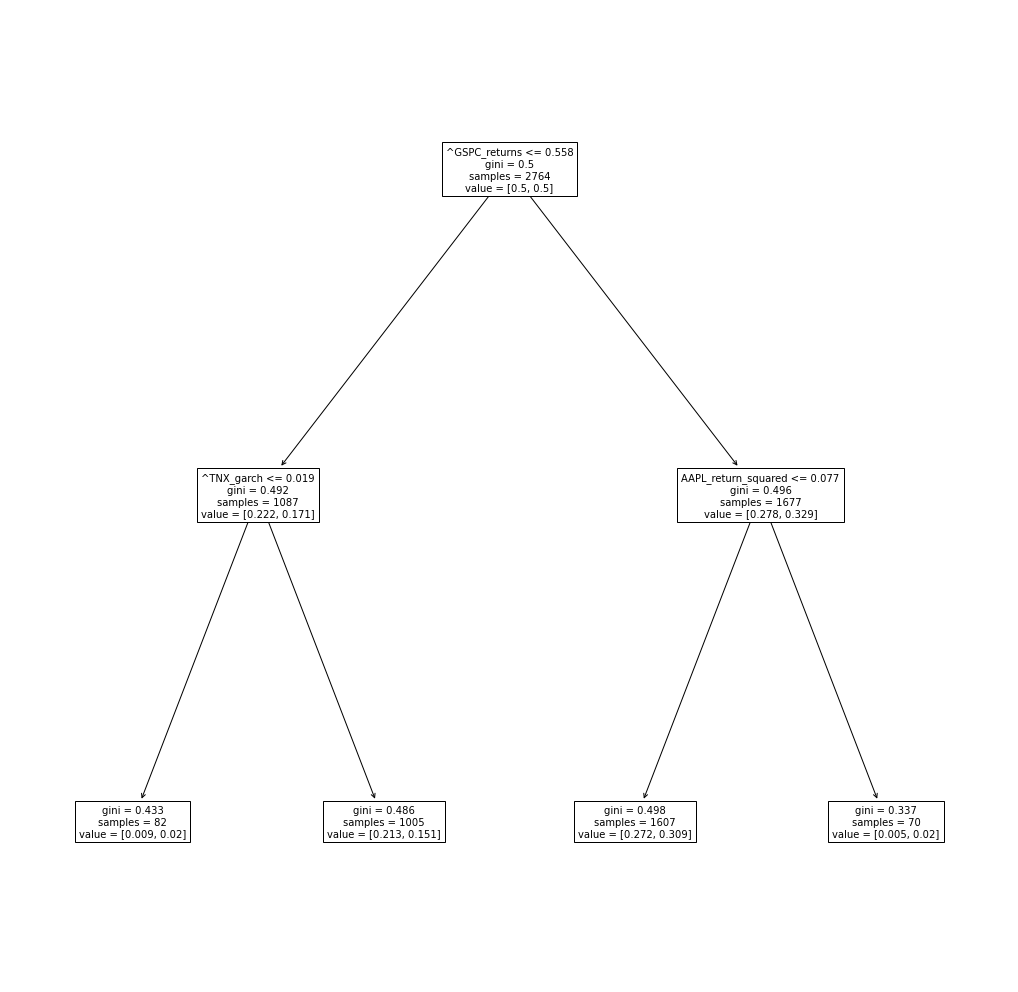

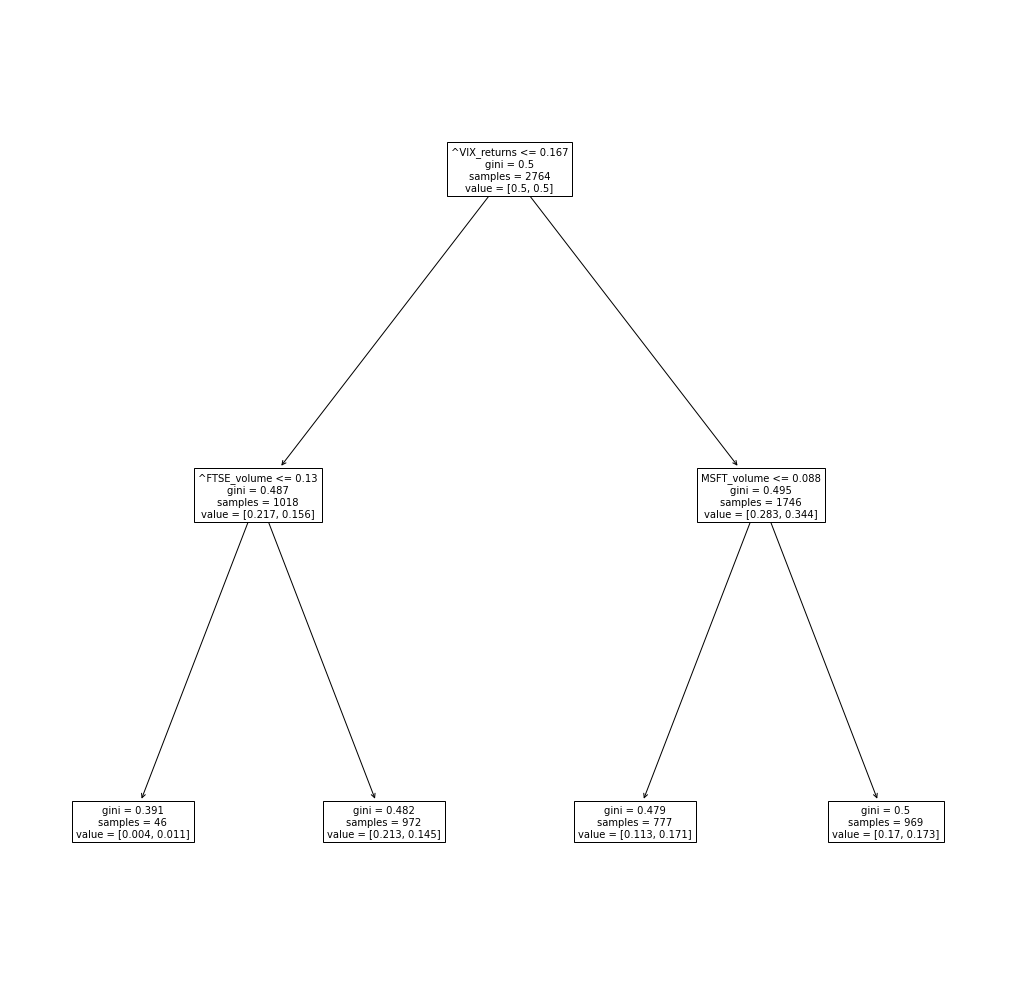

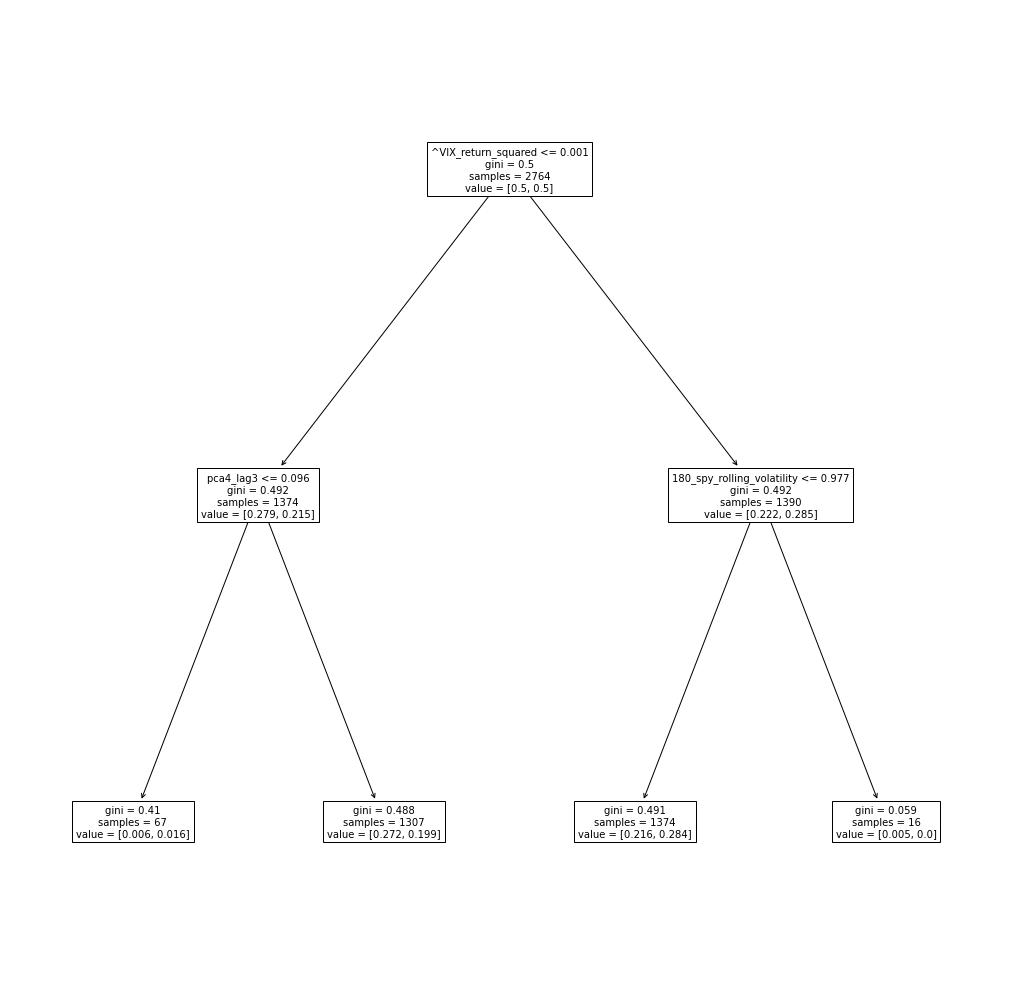

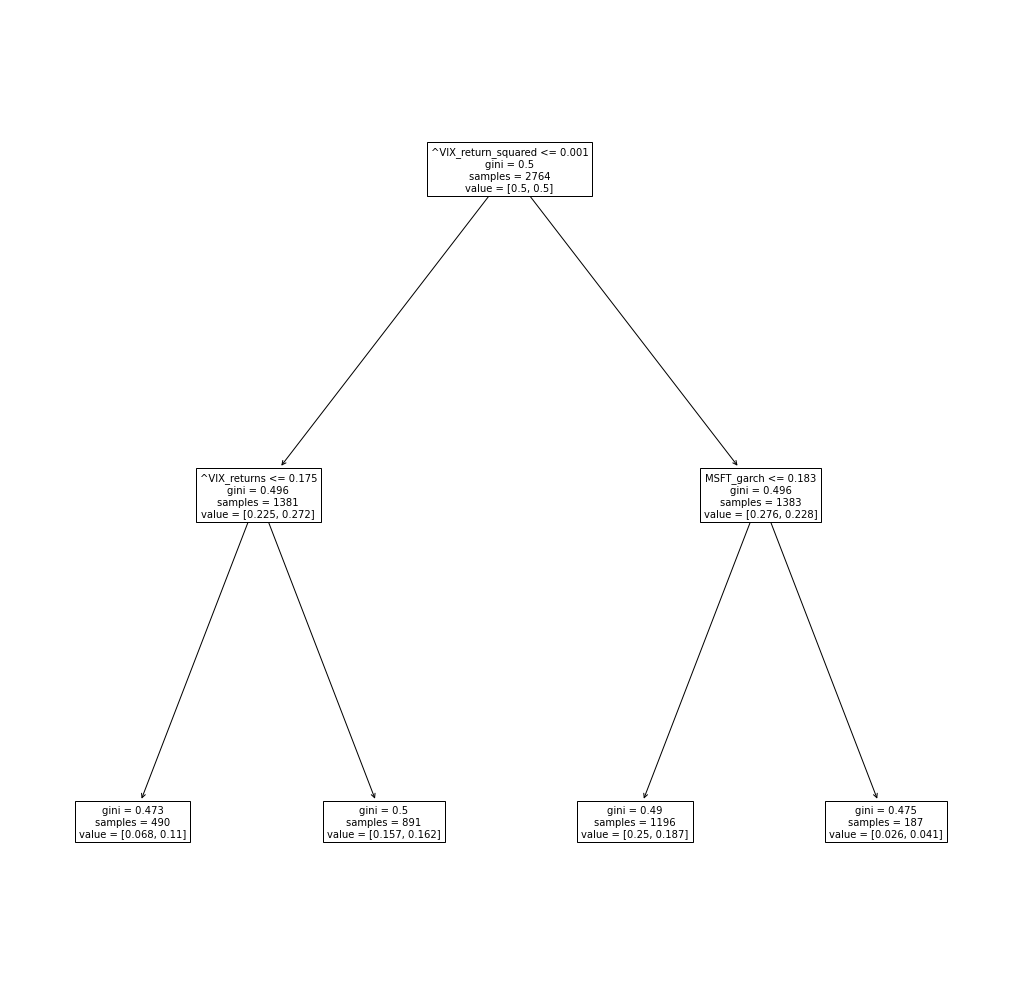

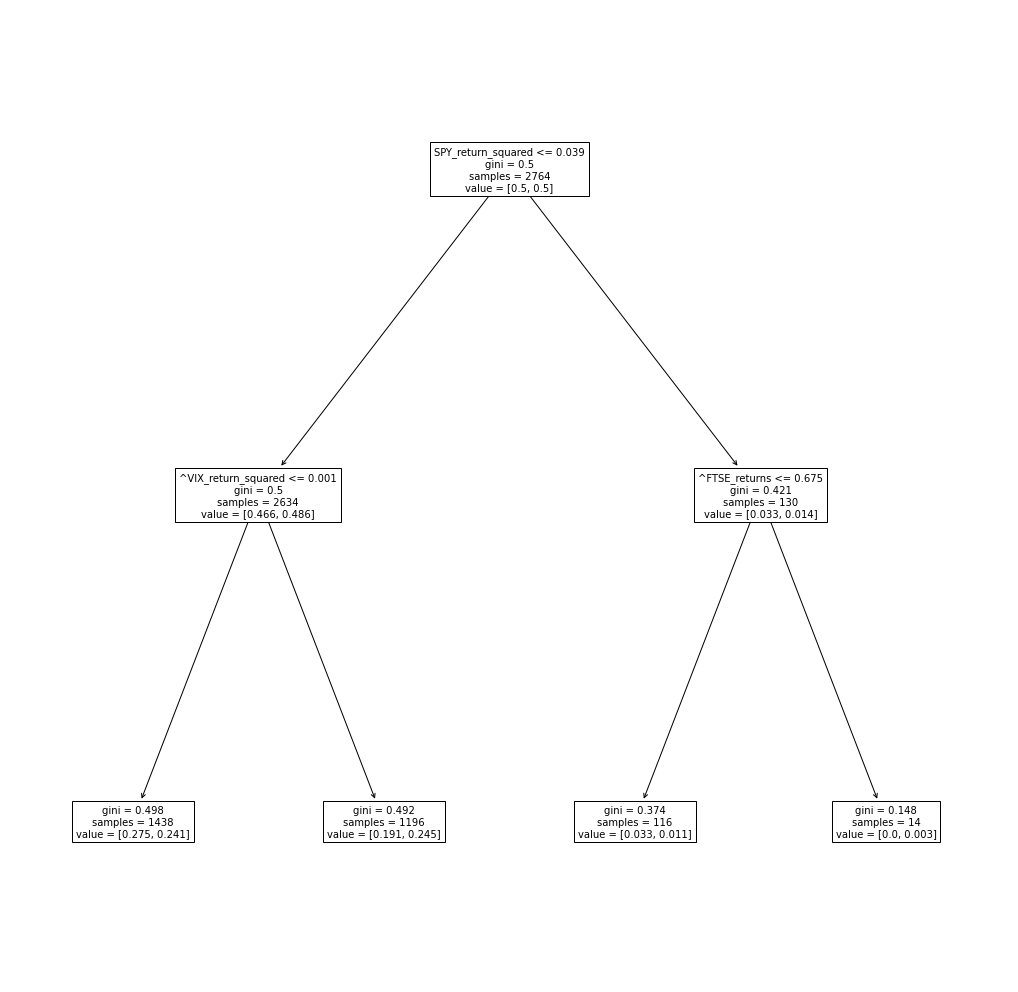

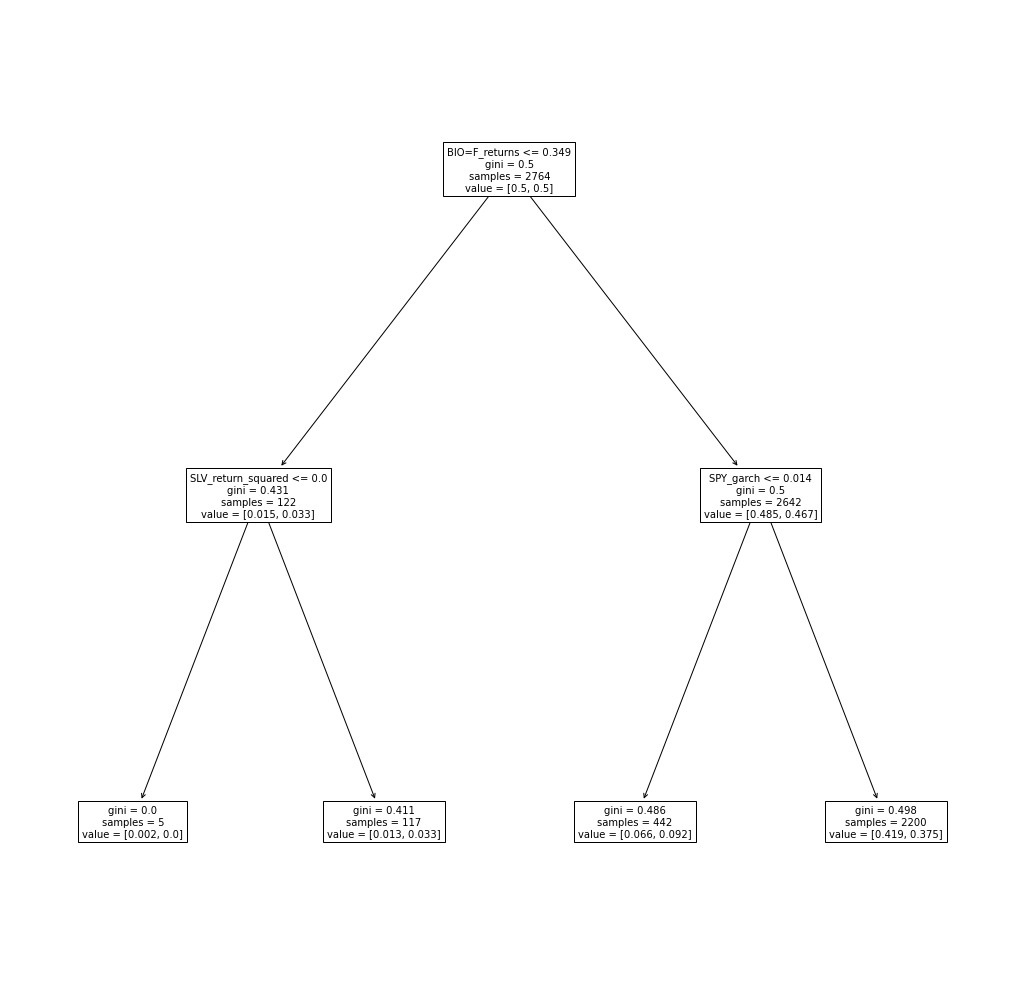

In [320]:
#import matplotlib.pyplot as plt
# plot tree

for i in range(0,len(adaboost_model.estimators_)):
    plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
    tree.plot_tree(adaboost_model.estimators_[i], fontsize=10, feature_names=X.columns, proportion=False)
    plt.show()

# Profitability Analysis


In [48]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics = abs(100 * security_returns_df['VIXM']).describe()
display(vixm_return_statistics)

count    2900.000000
mean        1.395715
std         1.501480
min         0.000000
25%         0.434465
50%         0.994112
75%         1.875514
max        18.214719
Name: VIXM, dtype: float64

In [49]:
#vixm_ret.loc['2011-02-21']
#y_train_df.index.min()  
#y_train_df.index.max()

### In-sample analysis: Return on $1 invested on training data window

In [50]:
# Results comnparison

# Profitability on the train window
fit_train = adaboost_model.predict(X_train_scaled)
fit_train_df = pd.DataFrame(fit_train, index = X_train.index)

fit_train_df.hvplot()

y_train_df = pd.DataFrame(y_train, index=X_train.index)

vixm_returns_train_df = vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
vixm_returns_train_df = vixm_returns_train_df.loc[y_train_df.index]


# SPY as benchmark
spy_in_sample_period_returns = security_returns_component_df['spy'].loc[y_train_df.index.min():y_train_df.index.max()]


results_train_df = pd.concat([vixm_returns_train_df, y_train_df, fit_train_df, spy_in_sample_period_returns], axis=1)
print(results_train_df)

results_train_df.columns = ['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY returns"]

predicted_return = np.multiply(results_train_df['VIXM Return'],results_train_df['Fit Signal'])
max_return = np.multiply(results_train_df['VIXM Return'],results_train_df['Correct Signal'])


results_train_df = pd.concat([results_train_df, predicted_return, max_return], axis=1)
print(results_train_df)

results_train_df.columns = ['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY Return", 'VIXCOIN Token Return', "Max Return"]


return_of_one_dollar_in_train_window_df = (1+results_train_df[['VIXM Return', "SPY Return", 'VIXCOIN Token Return', "Max Return"]]).cumprod()
return_of_one_dollar_in_train_window_df.columns=['VIXM ETN', "SPY Return", 'VIXCOIN Token(in sample)', "Max Return"]

profitability_train_plot=return_of_one_dollar_in_train_window_df[['VIXCOIN Token(in sample)','VIXM ETN' ]].hvplot(
                                             title="In-Sample Growth of $1 initial Investment in VIXCOIN Token",
                                             ylabel="Dollars $" ,
                                             width=1000,
                                             color=['green','red','blue']
 )

profitability_train_plot
#results_train_df[["Correct Signal", "Fit Signal"]].head(20)
#(1+predicted_return).cumprod().tail(400)
#return_of_one_dollar_in_train_window_df.tail()

            VIXM_ret  Signal    0       spy
Date                                       
2011-02-21  0.000000     1.0  1.0  0.000000
2011-02-22  0.059293     1.0  0.0 -0.020070
2011-02-23  0.026566     1.0  1.0 -0.006145
2011-02-24  0.001107     1.0  1.0 -0.000687
2011-02-25 -0.035941     0.0  1.0  0.010693
...              ...     ...  ...       ...
2021-02-15  0.000000     1.0  1.0  0.000000
2021-02-16  0.001446     1.0  1.0 -0.000866
2021-02-17 -0.001925     0.0  0.0  0.000229
2021-02-18  0.011333     1.0  1.0 -0.004256
2021-02-19  0.000477     1.0  0.0 -0.001766

[2610 rows x 4 columns]
            VIXM Return  Correct Signal  Fit Signal  SPY returns         0  \
Date                                                                         
2011-02-21     0.000000             1.0         1.0     0.000000  0.000000   
2011-02-22     0.059293             1.0         0.0    -0.020070  0.000000   
2011-02-23     0.026566             1.0         1.0    -0.006145  0.026566   
2011-02-24   

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [51]:
y_train_df.index

DatetimeIndex(['2011-02-21', '2011-02-22', '2011-02-23', '2011-02-24',
               '2011-02-25', '2011-02-28', '2011-03-01', '2011-03-02',
               '2011-03-03', '2011-03-04',
               ...
               '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
               '2021-02-12', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19'],
              dtype='datetime64[ns]', name='Date', length=2610, freq='B')

### Out-of--sample analysis: Return on $1 invested on training data window

In [52]:
# Results comnparison

# Profitability on the test window

# Out-of-sample Predictions 
prediction_test = adaboost_model.predict(X_test)
prediction_test_df = pd.DataFrame(prediction_test, index=X_test.index)

# Out-of-sample signals (1s or 0s) based on actual returns of the VIX
y_test_df = pd.DataFrame(y_test, index=X_test.index)
y_test_df

# VIXM returns in the test window
vixm_returns_df = vixm_ret.loc[y_test_df.index.min() : y_test_df.index.max()]
vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

# Combination of VIXM Returns, signals and predictions
results_test_df = pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
results_test_df.columns = ['VIXM Return', 'Correct Signal', 'Predicted Signal']

# Predicted returns
predicted_return = results_test_df['VIXM Return'] * results_test_df['Predicted Signal']
max_return = results_test_df['VIXM Return'] * results_test_df['Correct Signal']

# SPY as benchmark
spy_out_of_sample_period_returns = security_returns_component_df['spy'].loc[y_test_df.index]

# DataFrame with out-of-sample results for comparison
results_test_df = pd.concat(
    [results_test_df, predicted_return, max_return, spy_out_of_sample_period_returns], 
    axis=1
)
results_test_df.columns = [
    'VIXM Return', 'Correct Signal', 'Predicted Signal', 'Predicted Return', "Max Return", "Benchmark: SPY"
]

return_of_one_dollar_in_test_window_df = (
    1 + results_test_df[['Predicted Return','VIXM Return',  "Benchmark: SPY"]]
).cumprod()
return_of_one_dollar_in_test_window_df.columns = [
    'VIXCOIN Token (out of sample)', 'VIXM ETN', 'Benchmark: SPY ETF']


#Plot with out of sample return on a 1 dollar investment for the VIX, and the daily bet strategy

# Set plot and style options
roi_token = -1 + return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].iloc[-1]
roi_etn = -1 + return_of_one_dollar_in_test_window_df['VIXM ETN'].iloc[-1]
roi_spy = -1 + return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].iloc[-1]

title = f" Growth of $1 investment in VIXCOIN Token since October 2019.    Token Return: {roi_token*100:.1f}%  ETN Return: {roi_etn*100:.1f}% SPY Return: {roi_spy*100:.1f}%"
profitability_test_plot = return_of_one_dollar_in_test_window_df.hvplot(
    title=title,
    ylabel= "Dollars $",
    width=1200,
    height=500,
    color=["green","red","blue"]
    #,legend="bottom"
)

profitability_test_plot

#predicted_return.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [53]:
y_test.index

DatetimeIndex(['2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-03-01', '2021-03-02', '2021-03-03',
               '2021-03-04', '2021-03-05',
               ...
               '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-14'],
              dtype='datetime64[ns]', name='Date', length=276, freq='B')

In [54]:
# Bar graph comparison of returns
start_date_plot = str(results_test_df.index[0].date())
title = f"Out-of-Sample Cummulative Return on Investment Comparison. Starting period: {start_date_plot}"
roi_plot_df = (100*return_of_one_dollar_in_test_window_df)
roi_plot_df.columns = ["VIXCOIN Token", "VIXM ETN", "SPY ETF"]
roi_plot_df = roi_plot_df.iloc[-1]

roi_plot_df.hvplot(
    kind='bar',
    ylabel='Return (%)',
    title=title
    )


:Bars   [index]   (2022-03-14 00:00:00)

In [55]:
# Token growth in out-of.sample window. Like a pricing example if token is set to $1 at the start of the testing window
# Generating a plot that contains the growth of the Token compared to the SPY since Oct 2019. 
# Key points are marked "^" to emphasize levels like maximum, minimum, first, last.

# Set plot and style options
roi_token = (1 + predicted_return).cumprod()[-1]
title = f"VIXCOIN Token Pricing example, if initiated in Feb 2021.                Current price: {roi_token:.2f}"

token_price_curve_plot = return_of_one_dollar_in_test_window_df.hvplot(
    y=['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF'],
    title=title,
    ylabel="Dollars $",
    width=1100,
    color=["green","blue"]
)

first_point = return_of_one_dollar_in_test_window_df.head(1)
last_point = return_of_one_dollar_in_test_window_df.tail(1)
max_token = return_of_one_dollar_in_test_window_df[
    return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'] == 
    return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].max()].head(1)
min_spy = return_of_one_dollar_in_test_window_df[return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'] == 
    return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].min()].head(1)

key_points = pd.concat([first_point, min_spy, max_token, last_point], axis=0)
key_points_token = key_points['VIXCOIN Token (out of sample)']
key_points_spy = key_points['Benchmark: SPY ETF']

token_key_point=return_of_one_dollar_in_test_window_df[
    ['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF']
    ].loc[key_points.index].hvplot(
        kind='scatter',
        marker="^",
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400,
        color=['green','blue']
)

token_key_point*token_price_curve_plot


:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Scatter   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [56]:
key_points.index

DatetimeIndex(['2021-02-22', '2021-03-04', '2022-03-14', '2022-03-14'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
prediction_plot = (
    prediction_test_df.hvplot(
        width=1200,
        kind='bar',
        color=['black']
    ) *
    (5 * vixm_returns_df).hvplot(
        kind='bar',
        color=["yellow"],
        title="How the algorithm avoids time decay?",
        ylabel="Signal and VIXM x5 Return"
    )
)

prediction_plot

In [ ]:
# TOKEN PRICE and JSON FILE

# Set date_start_token and calculate date_after_start_token dynamically
date_start_token = '2020-12-31'
date_start_token_dt = datetime.strptime(date_start_token, '%Y-%m-%d')
date_after_start_token = (date_start_token_dt + timedelta(days=1)).strftime('%Y-%m-%d')

# Output for JSON
# CSV file with [token value, VIXM, SPY] for all history
y_hat_df = pd.concat([fit_train_df, prediction_test_df], axis=0)
y_hat_df.columns = ['Signal_hat']
jason_df = pd.concat([y_hat_df, X2['VIXM_returns'], X2['spy_returns'], X1['VIXM_close'], X1['spy_close']], axis=1)

# Calculate growth of $1 investment
growth_1dollar_investment_df = (1 + jason_df[['VIXM_returns', 'spy_returns']]).cumprod()
print(growth_1dollar_investment_df)
growth_1dollar_investment_df.rename(
    {'VIXM_returns': 'VIXM_growth_1dollar', 'spy_returns': 'spy_growth_of_1dollar'}, 
    axis=1, inplace=True
)

# Concatenate growth data into the main DataFrame
jason_df = pd.concat([jason_df, growth_1dollar_investment_df], axis=1)
jason_df["Signal_hat"] = jason_df["Signal_hat"].fillna(0)

# Calculate Token returns and growth
token_returns = np.multiply(jason_df['Signal_hat'], jason_df['VIXM_returns'])
token_returns.fillna(0, inplace=True)
token_growth_df = (1 + token_returns).cumprod()

# Set Token price
token_price_df = token_growth_df.copy()
token_price_df[token_price_df.index < date_start_token] = 0
token_price_df[token_price_df.index >= date_start_token] = (
    token_growth_df[token_growth_df.index >= date_start_token] / 
    token_growth_df[date_start_token]
)

# Concatenate Token data into the main DataFrame
jason_df = pd.concat([jason_df, token_returns.rename('Token_returns'), token_growth_df.rename('VIXCOIN_token_growth_1dollar'), token_price_df.rename('Token_price')], axis=1)
print(f"jason_df: {jason_df}")

# Update column names
jason_df.columns = [
    'Signal_hat', 'VIXM_returns', 'spy_returns', 'VIXM_close', 'spy_close',
    'VIXM_growth_1dollar', 'spy_growth_of_1dollar', 'Token_returns',
    'VIXCOIN_token_growth_1dollar', 'Token_price'
]

# Drop NaN values and output to CSV
jason_df.dropna().to_csv("demo_data/Jason_output_file.csv", index=True)

# Token graph: Growth of SPY and VIXM, compared to the token price
spy_growth_vs_token = pd.DataFrame(
    (1 + security_returns_df.loc[date_after_start_token:, ['spy', "VIXM"]]).cumprod(),
    index=security_returns_df.loc[date_start_token:, 'spy'].index
)
spy_growth_vs_token.loc[date_start_token, ['spy', "VIXM"]] = 1
spy_growth_vs_token['Token'] = jason_df.loc[date_start_token:, 'Token_price']

# Plot Token price vs VIXM and SPY
token_price_vs_vixm = spy_growth_vs_token.iloc[:, 1:3]

end_date = spy_growth_vs_token.index[-1].strftime('%Y-%m-%d')
title = f"VIXCOIN Token Price. Price as of {end_date}: ${token_price_df.iloc[-1]:.2f}"

graph2 = token_price_vs_vixm.hvplot(
    legend='bottom',
    title=title,
    height=500,
    ylabel="$",
    color=['red', 'green']
)

display(graph2)

spy_growth_vs_token

### Comments
0. The VIXM invest in VIX Futures in order to make profit.
1. The VIXM has massive positive returns in moments of crushes in the market, and tends to decay in time due to the rolling effect on its futures contracts. 
2. Due to the decay effect, VIXM can only be profitable for short term trades. Should not be used in a buy and hold strategy.
3. Our algorithmic trading investment strategy on VIXM takes advantage of the good return in market crushes, and in addition allows to generate profit during bull markets.
4. The VIXCoin investment works like a buy and hold strategy, and offers an investment opportunity to diversify a portfolio to reduce risk.


In [ ]:
# Results in prediction of daily returns
min_return = threshold
results_test_for_plot_df = results_test_df[abs(results_test_df['VIXM Return'])>min_return]*100

results_test_for_plot_df.hvplot(
    y=['VIXM Return', 'Predicted Return'],
    title="Out-of-sample predictions of VIXM return",
    width=1000,
    ylabel='Daily Return (%)'
)

In [ ]:
#Histogram of returns out of sample
results_test_for_plot_df.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title="Out-of-sample VIXM returns predictions"
)

### Analysis of good and bad predictions

In [ ]:
# Analysis of the good and bad out-of-sample predictions
good_predictions=results_test_df[
    results_test_df['Correct Signal'] == results_test_df['Predicted Signal']
]

bad_predictions = results_test_df[
    results_test_df['Correct Signal'] != results_test_df['Predicted Signal']
]

In [ ]:
good = good_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title="Out-of-sample VIX Returns of Good Predictions"
)

bad = bad_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title="Out-of-sample VIX Returns on Bad Predictions"
)
good+bad

### Observations
We see that the number of negative returns that are dismissed are similar to the ones avoided when returns are small. However, for large tailed negative returns, there are significantly many more that are avoided (9+6 =15) than the ones that are not avoided (3+1 = 4 )

In [ ]:
# Good prediction statistics
good_predictions[['VIXM Return', 'Predicted Return']].describe()

In [ ]:
# Bad prediction statistics
bad_predictions[['VIXM Return', 'Predicted Return']].describe()

In [ ]:
# Box Plot predictions for good and bad predictions
good_pred = good_predictions['Predicted Return']
bad_pred = bad_predictions['Predicted Return']

predictions_comparison_df = pd.concat(
    [good_predictions['Predicted Return'],bad_predictions['Predicted Return']], 
    axis=1, 
    ignore_index=True
)*100
predictions_comparison_df.hvplot(
    kind='box',
    height=800,
    ylabel='Return (%)',
    #clabel=['Good Predictions', 'Bad Predictions'],
    cmap=['blue','red'],
    title="Out-of-sample Good and Bad Returns Resulting from Model Predictions Box Plots"
)

#df = pd.DataFrame(np.random.randn(20), columns=['Value'])
#df['Source'] = ['Preds'] *10 +['Real'] * 10
#df['Item'] = ['item1'] *5 + ['item2']*5 + ['item1'] *5 + ['item2']*5
#df.hvplot.box(y='Value', by=['Item', 'Source'])

#n_estimators 22, Trying deph 1, learning rate 1.8 -- get to perfect accuracy.